This notebook is devoted to perform hyperparameter tunning of a DDQN agent in order to solve a pretty basic environment as Cartpole-v0. Besides learning how different hyperparameters affect the learning curve of our agent, this project is aimed at sanity checking the implementation of my agent, which will be used later on to solve more complex environments.

In [1]:
import glob
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from utils import create_settings, create_key, save_data, solve_metric, load_agent_results, creage_avg
import seaborn as sns
import sys
sys.path.insert(1,'/home/axelbm23/Code/ML_AI/Algos/ReinforcementLearning/')
from agents import DDQN,Agent_Performance
import time
import tensorflow as tf
import tf_keras
from typing import Any,Optional

2024-07-22 11:35:12.525391: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 11:35:12.567965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 11:35:13.219777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We will conduct some analysis on four different parameters as they seem seem to be the ones that affect the results in a major degree. For each parameter, we will produce 3 runs, as RL algorithms are more heavily influenced by the initial conditions (i.e network weights) that other techniques. The parameters we will play with are:
1) complexity of the network, i.e number of layers and number of nodes per layer
2) Learning rate of our optimizer
3) batch size
4) type of update on the target network, either soft update or hard copy.
5) greedy step, i.e how large the exploratio phase is

In [2]:
# Set up the default values
N_ITERATIONS = 3
GAMMA = 0.99
GREEDY_STEP = 999e-3
EPISODES = 600
BUFF_SIZE = 1_000
BATCH_SIZE = 64
NN_COPY_CADENCY = 10
SOFT_UPDATE = 0.005
NEURONS = [128]*2
ACT_AS_IN = False
ADD_LOGS = False
LOSS_FUNC = 'mean_squared_error'
ADAM_LR = 0.001
OUTPUT_PATH = f'{os.getcwd()}/results/rewards_losses'
SOLVED = 195
OVERWRITE = False

# According to openai/gym/wiki
# Cartpole-v0 is solved when it reaches an average reward
# of 195 over 100 consecutive episodes
env = gym.make("CartPole-v0")
def_nn_arch = {'neurons': NEURONS,
               'action_as_input':ACT_AS_IN,
                'loss_function': LOSS_FUNC,
                'optimizer': tf.keras.optimizers.Adam(learning_rate=ADAM_LR),
                }

def_agent = {'gamma': GAMMA,
            'greedy_step': GREEDY_STEP,
            'environment': env,
            'episodes': EPISODES,
            'buff_size': BUFF_SIZE, 
            'replay_mini_batch': BATCH_SIZE,
            'nn_copy_cadency': NN_COPY_CADENCY,
            'nn_architecture': def_nn_arch,
            'soft_update': SOFT_UPDATE,
            'add_logs':ADD_LOGS}

/home/axelbm23/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
2024-07-22 11:35:15.823879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 11:35:15.864447: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 11:35:15.864485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 11:35:15.870263: I external/local_xla/xla/stream_executor/cuda/c

In [3]:
# Create different settings for each one of the experiments
network_arch_sett = ([64]*2,[256]*4)
lr_sett = [0.1,0.05]
batch_siz_sett = [32,128]
target_update_sett = [(25, 0.01),(None,0.005), (None,0.01)]
greedy_step_sett = [99e-2, 9985e-4]
experiment = {'nn_arch':network_arch_sett,
               'lr':lr_sett,
               'target_update':target_update_sett,
               'greedy_step':greedy_step_sett,
               'default':[None]}

Train our agent for each set of parameters

In [4]:
total_experiments = N_ITERATIONS*sum([len(exp_i) for exp_i in experiment.values()])
if OVERWRITE:
   i = 0
   for key,val in experiment.items():
      for sett_i in val:
         sett_key = create_key(sett_i)
         for it in range(N_ITERATIONS):
            ag_sett = create_settings(key,sett_i,def_nn_arch, def_agent)
            model_label = f'{key}_{sett_key}_iter_{it}'if key!='default' else f'{key}_iter_{it}'
            # Initialize the class again as the network weights need to be random
            ddqn = DDQN(sett=ag_sett)
            t1 = time.time()
            rewards, losses, logs = ddqn.learn()
            exec_time = round(time.time()-t1, 3)
            
            # Save all the information we need for the post analysis,
            # basically execution time, rewards and losses
            save_data(rewards, losses, exec_time, model_label, OUTPUT_PATH)
            i += 1 
            print(f'Progress..{round(i/total_experiments,3)}')
            
   print(f'All data has been created')
else:
   print(f'Data already created will be loaded')

Data already created will be loaded


We will perform two tasks here. The first one will be to analyze the reward/loss function of each individual try of the algorithm to make some hypothesis about what is going on with it. The second part, will be to compute some performance metrics to quantify the algorithm performance across different dimensions.

In [5]:
results_dfs = load_agent_results(OUTPUT_PATH)

In [24]:
# Create statistics for all the experiments
stats = {}
for param, df in results_dfs.items():
    rew = df.groupby(['iter'])['rewards'].apply(lambda x: x.to_numpy())
    loss = df.groupby(['iter'])['losses'].apply(lambda x: x.to_numpy())
    ag_perf = Agent_Performance(rewards=rew, losses=loss, solved_func=solve_metric, solved_rew=SOLVED)
    stats[param] = ag_perf.compute_statistics(prec=3)
stats_df = pd.DataFrame.from_dict(stats).T
stats_df.sort_index(inplace=True)

,avg_end_rew,best_worst_ratio_end_rew,avg_epi_rew,avg_epi_rew_increase,std_epi_rew_increase,n_solved,avg_ep_to_solve,max_drawdown
default,392.333333,1.793991,146.744957,0.812996,97.889932,3.0,462.666667,709.000000
greedy_step_0.99,983.333333,187.300000,97.291577,2.072150,102.441650,2.0,394.500000,460.000000
greedy_step_0.9985,154.666667,25.333333,108.610975,0.309524,104.823676,2.0,310.500000,847.666667
lr_0.05,26.000000,3.800000,64.321667,0.017251,59.762370,0.0,NaN,491.333333
lr_0.1,18.333333,1.300000,19.385556,-0.005565,15.049310,0.0,NaN,150.666667
nn_arch_256-256-256-256,643.333333,125.600000,95.531899,1.369517,138.424445,1.0,148.000000,508.666667
nn_arch_64-64,489.000000,5.753623,143.548279,1.177609,138.392650,3.0,397.000000,1404.000000
target_update_25-0.01,814.333333,124.058824,81.570767,1.587806,73.423800,2.0,456.000000,245.333333
target_update_None-0.005,1081.000000,110.000000,83.987981,3.823884,350.707406,2.0,116.000000,1815.666667
target_update_None-0.01,2080.000000,19.828326,157.397119,12.824017,256.466282,3.0,162.000000,635.333333


Study the different parameters independently

,episodes,rewards,losses,exec_time,iter,rew(mavg)
0,0,25.0,0.000000,3610.737,2,NaN
1,1,20.0,0.000000,3610.737,2,NaN
2,2,25.0,1.627132,3610.737,2,NaN
3,3,20.0,0.196839,3610.737,2,NaN
4,4,26.0,0.006105,3610.737,2,NaN
...,...,...,...,...,...,...
1343,143,257.0,10.367915,1324.604,1,201.200000
1344,144,237.0,4.595638,1324.604,1,208.266667
1345,145,33.0,0.850465,1324.604,1,209.533333
1346,146,1162.0,38.211112,1324.604,1,286.200000


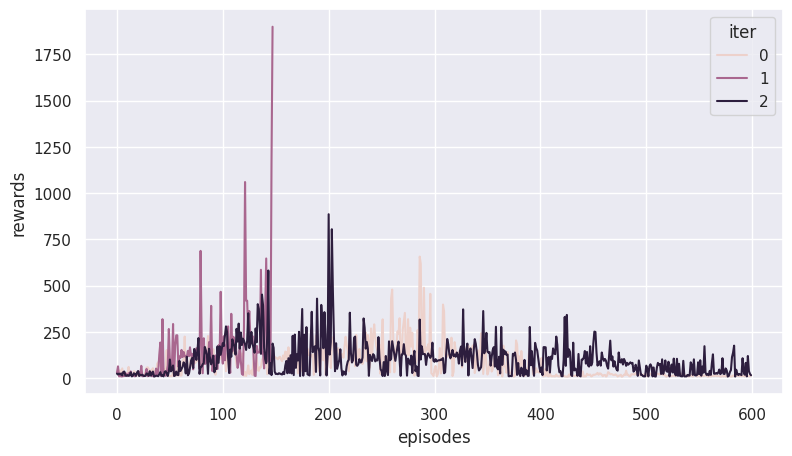

In [18]:
#df_to_plot['episodes'].ndim
fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=results_dfs['nn_arch_256-256-256-256'], x='episodes', y='rewards', hue='iter')
#sns.despine()
plt.show()